In [44]:
import numpy as np

from dataSetPreProcessing import train_validation_test_split
from sklearn.model_selection import train_test_split
from loadDataSet import loadMainDataSet,loadTesteDataSet,loadCompletDataSet,loadMainDataSetWithElevation
from tools import verifyArgs,findBalancedDataSet,pltResults,pltCorrelation, pltLossGraph,pltShow,plotXY,getMetrics,plotLeanrningCurve,getBalancedDataSetIndexRandomState

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [45]:
# Carregar conjunto de dados
dataSet,features_names,target_names = loadMainDataSetWithElevation()

    Latitude  Longitude  Elevation     Ca      Mg     Na     Cl
0 -14.875833 -39.901389   282.6006  120.0  141.00  172.0  660.0
1 -14.853333 -39.661111   184.0000    0.8    1.45    4.3    7.0


In [46]:

def getParamGrid():
    '''Função que retorna os parâmetro utilizados para encontrar 
    o conjunto de treino balanceado e também na tunagem.
    '''
    param_grid_half = {
        
        'bootstrap': [True],
        'max_depth': [None,10,50],
        'max_features': ['auto','log2'],
        'min_samples_leaf': [1,2,3,4],
        'n_estimators':[10,50],
    }
    param_grid_full = {
        
        'bootstrap': [True],
        'max_depth': [None,10,50,100],
        'max_features': ['auto','log2'],
        'min_samples_leaf': [1,2,3,4],
        'n_estimators':[10,50,100,200],
    }
    return param_grid_half,param_grid_full

In [47]:
def tuningParameters(model,param_grid,X_train,y_train,verbose=0):
    '''Função que realiza o tuning de parâmetros e também a validação cruzada.'''
    reg =GridSearchCV(model, cv=10,param_grid=param_grid,verbose=verbose,n_jobs=-1,scoring='r2',iid=True)
    reg.fit(X_train,y_train)
    
    print("#Best score:",reg.best_score_)
    print("#Best params:",reg.best_params_)
          
    return reg.best_estimator_,reg.best_params_,reg.best_score_

In [48]:

def getBestSeed(X,y,faixa,verbose=0):
    '''Função responsável por retornar a semênte randômica para a replicação do conjunto de dados balanceado'''
    param_grid_half,_ = getParamGrid()
    maior_score = 0
    seed = 0
    for i in faixa:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=i)
        model = RandomForestRegressor(random_state=0)
        best_model,best_params,best_score = tuningParameters(model,param_grid_half,X_train,y_train)
        if best_score>maior_score:
            maior_score = best_score
            seed = i

        y_train_pred = best_model.predict(X_train)
     
    if verbose:
        print("#Maior Score: ",maior_score)
        print("#Seed : ",seed)
   
    return seed,maior_score

In [49]:
def runTest(target,verbose=0):
    '''Executar a busca do melhor modelo para os conjuntos de entrada e o target'''
    X = dataSet[:,:4]
    y = dataSet[:,target]
    seed,score = getBestSeed(X,y,range(1,10),verbose=verbose)

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=seed)
        
    _,param_grid_full = getParamGrid()
    tuningParameters(RandomForestRegressor(random_state=0),param_grid_full,X_train,y_train,verbose=verbose)

    print("#Best Seed:",seed)


In [57]:

def avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,param_key_loss,target,verbose=0,stepLoss=25):
    '''Função responsável por apresentar os resultados para cada modelo obtido.'''
    model.fit(X_train,y_train)

    plotLeanrningCurve(X_train,X_val,y_train,y_val,model,param_key_loss,'mean_squared_error',legend_1="Treino",legend_2="Validação",verbose=verbose,step=25)
    plotLeanrningCurve(X_train,X_val,y_train,y_val,model,param_key_loss,'r2',legend_1="Treino",legend_2="Validação",verbose=verbose,step=25)
    
    y_train_pred = model.predict(X_train)
    print("#Metricas para os dados de treino")
    getMetrics(y_train,y_train_pred,verbose=1)
    plotXY(y_train,y_train_pred,"Treino","Predito",target_names[target],"Treino X Predito",midle_line=True)
    
    y_val_pred = model.predict(X_val)    
    print("#Metricas para os dados de validação")
    getMetrics(y_val,y_val_pred,verbose=1)
    plotXY(y_val,y_val_pred,"Validação","Predito",target_names[target],"Validação X Predito",midle_line=True)
     
    y_test_pred = model.predict(X_test)
    print("#Metricas para os dados de teste")
    getMetrics(y_test,y_test_pred,verbose=1)    
    plotXY(y_test,y_test_pred,"Teste","Predito",target_names[target],"Teste X Predito",midle_line=True)
    
    pltCorrelation(model,features_names)

    pltShow()
    

In [68]:


def MELHOR_MG(verbose=0):
    params = {'random_state':0,'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}
    model = RandomForestRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,4]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=9)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=7) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',0,verbose=verbose,stepLoss=25,)

    #Best Seed 9
    #Best score: 0.7392468312678826
    #Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 50}
    #Metricas para os dados de treino
    #R-squared: 0.89478
    #Mean Squared Error: 0.00274
    #Metricas para os dados de validação
    #R-squared: 0.80952
    #Mean Squared Error: 0.00351
    #Metricas para os dados de teste
    #R-squared: 0.73546
    #Mean Squared Error: 0.00421





In [69]:

def MELHOR_NA(verbose=0):
    params = {'random_state':0, 'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 500}
    model = RandomForestRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,5]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=3)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=0) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',1,verbose=verbose,stepLoss=25,)
    #Best score: 0.6317466186857145
    #Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100}
    #Best Seed: 2
    #Metricas para os dados de treino
    #R-squared: 0.94054
    #Mean Squared Error: 0.00149
    #Metricas para os dados de validação
    #R-squared: 0.63224
    #Mean Squared Error: 0.00739
    #Metricas para os dados de teste
    #R-squared: 0.79878
    #Mean Squared Error: 0.00460


In [70]:

def MELHOR_K(verbose=0):
    params = {'random_state':0, 'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 500}
    model = RandomForestRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,6]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=0) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',2,verbose=verbose,stepLoss=25,)
    #Best score: 0.6317466186857145
    #Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100}
    #Best Seed: 2
    #Metricas para os dados de treino
    #R-squared: 0.94418
    #Mean Squared Error: 0.00131
    #Metricas para os dados de validação
    #R-squared: 0.58730
    #Mean Squared Error: 0.00872
    #Metricas para os dados de teste
    #R-squared: 0.88894
    #Mean Squared Error: 0.00299

#Metricas para os dados de treino
#R-squared: 0.89486
#Mean Squared Error: 0.00274
#Metricas para os dados de validação
#R-squared: 0.81018
#Mean Squared Error: 0.00350
#Metricas para os dados de teste
#R-squared: 0.73634
#Mean Squared Error: 0.00420


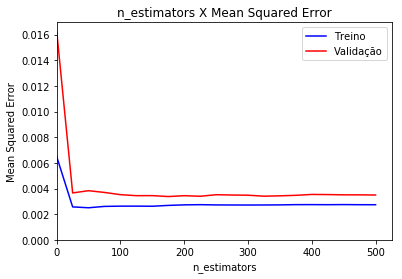

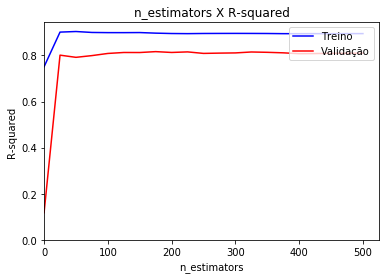

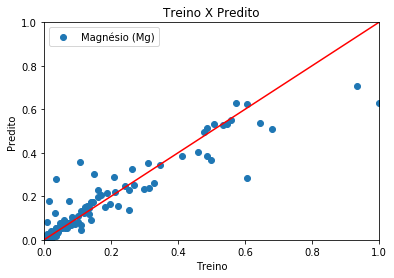

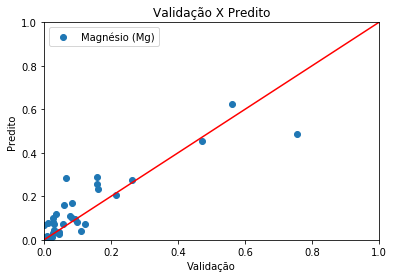

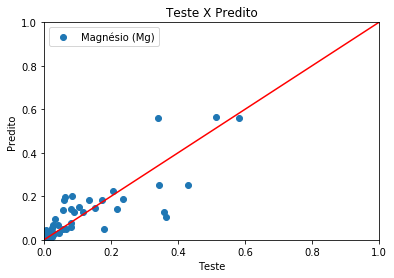

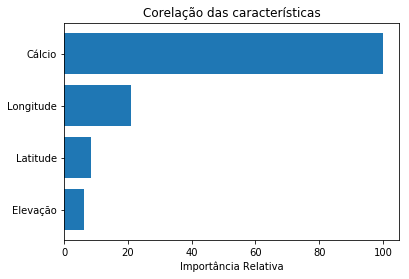

In [71]:
MELHOR_MG()

#Metricas para os dados de treino
#R-squared: 0.94015
#Mean Squared Error: 0.00150
#Metricas para os dados de validação
#R-squared: 0.63200
#Mean Squared Error: 0.00740
#Metricas para os dados de teste
#R-squared: 0.79779
#Mean Squared Error: 0.00463


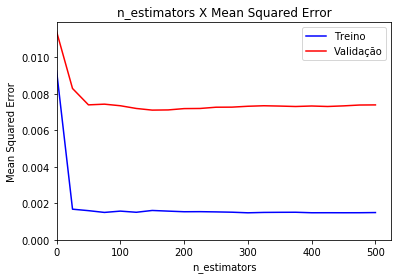

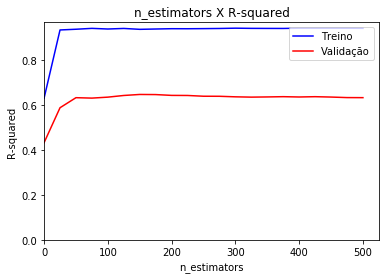

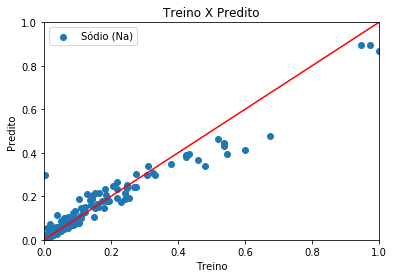

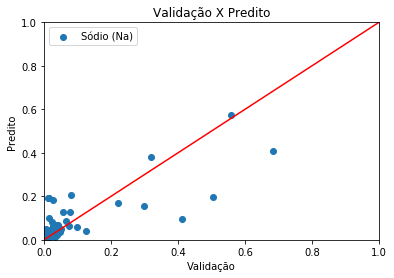

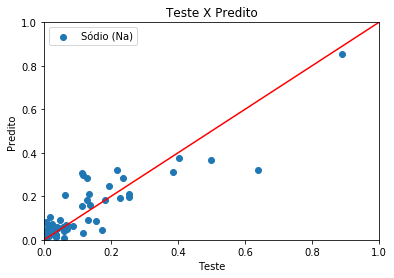

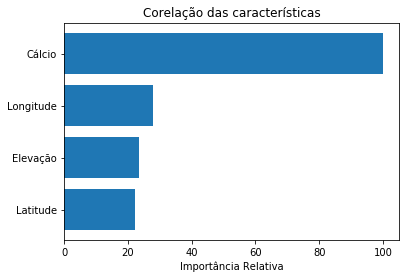

In [72]:
MELHOR_NA()

#Metricas para os dados de treino
#R-squared: 0.94440
#Mean Squared Error: 0.00131
#Metricas para os dados de validação
#R-squared: 0.57988
#Mean Squared Error: 0.00887
#Metricas para os dados de teste
#R-squared: 0.88681
#Mean Squared Error: 0.00304


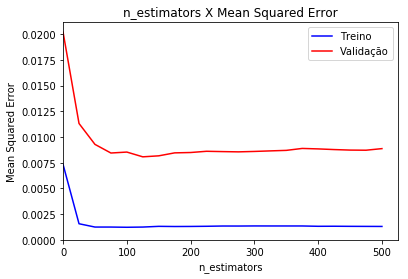

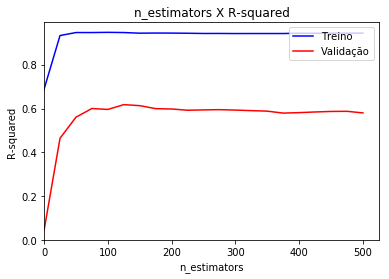

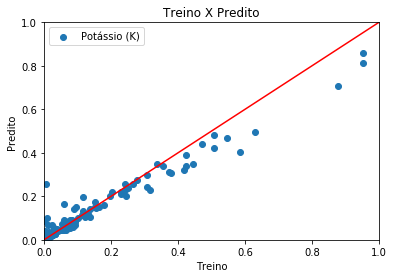

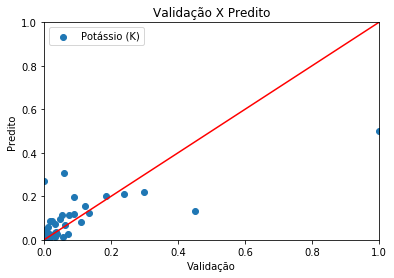

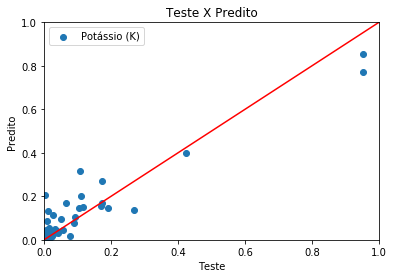

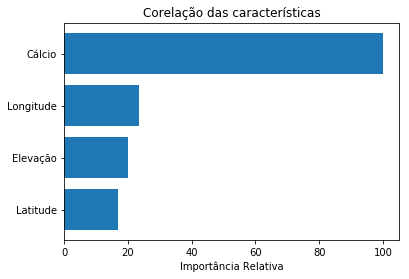

In [73]:
MELHOR_K()